# Stima dell'efficacia di un vaccino

La stima dell'efficacia di un vaccino è argomento di grande attualità. Il 30/12/2020 è stata pubblicata l'analisi dell'efficacia del vaccino della Pfitzer contro il Sars-Cov-2 in [N Engl J Med 2020; 383:2603-2615](https://www.nejm.org/doi/full/10.1056/NEJMoa2034577). Il 2/2/2021 è stata pubblicata l'analisi dell'efficacia del vaccino Sputnik V in [Lancet 2021; 397: 671–81](https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(21)00234-8/fulltext)

Nel seguito vediamo un metodo semplificato ma corretto per la determinazione dell'efficacia da un capione di persone vaccinate ed un campione di persone che hanno ricevuto un placebo.

In generale, si inietta il vaccino ad $N_1$ persone ed un placebo ad $N_0$ persone e si monitora, nel tempo, quante persone si infettano nei due campioni. Dopo un tempo inziale in cui il vaccino non è ancora efficace, il tasso di infezioni dovrebbe diminuire nel campione vaccinato rispetto al campione che ha ricevuto il placebo. Le persone che partecipano al test non sanno se hanno ricevuto vaccino o placebo, così che non ci sia alcuna informazione che induca differenti stili di vita che potrebbero modificare la probabilità di infettarsi.

In [61]:
import math
import numpy as np
import pandas as pd
import scipy.optimize
from scipy.stats import binom
from scipy.stats import norm
import matplotlib.pyplot as plt

## Tasso di contagio in assenza di vaccino

Se sappiamo di avere in Italia circa $15\,000$ infettti al giorni su 60 milioni di abitanti (situazione Covid19  nel 2021), circa, possiamo calcolare la **probabilità di infettersi in $n$ giorni per una persona non vaccinata**, come:

$p_0 = 1-(1-p_{0,1\mathrm{g}})^n \simeq n\cdot p_{0,1\mathrm{g}}$ se $p_{0,1\mathrm{g}}\ll 1$. 

Il pedice "0" sta per "non vaccinato". Useremo "1" per vaccinato.

dove $p_{0,1\mathrm{g}}$ è la probabilità di infettarsi in un giorno per una persona che non si è vaccianta.

In [67]:
# Italia, 15.000 casi su 60M al giorno
p1g = 15000/60000000
ng = 30
p0 = 1 - math.pow(1 - p1g, ng)
print('p(1g): {:.4%}'.format(p1g))
print('p0: {:.4%}'.format(p0))
# stima approssimata pià semplice
p0_1 = p1g*ng
print('p0[*]: {:.4%}'.format(p0_1))

p(1g): 0.0250%
p0: 0.7473%
p0[*]: 0.7500%


Assumendo un'efficacia $\varepsilon$ possiamo calcolare la **probabilità di infettarsi entro $n$ giorni per un vaccinato** come:

$p_1 = p_0\,(1-\varepsilon)$

Assumiamo un'efficienza $\varepsilon$ del 90% per generare un campione simulato.

In [68]:
eff = 0.9
p1 = p0*(1 - eff)

## Campioni di test e di controllo

Supponiamo di avere $N_0$ persone non vaccinate (es.: vaccinate con un *placebo*) e $N_1$ persone vaccinate. 

Si può calcolare quanti casi di infezioni $I_1$ e $I_0$ ci si aspetta tra vaccinati e tra non vaccinati nel periodo di osservazione di $n$ giorni:

$\mathbb{E}[{I_0}] = p_0\, N_0$

$\mathbb{E}[{I_1}] = p_1\, N_1 = p_0\,(1-\varepsilon) N_1$

In [71]:
n0, n1 = 10000, 10000
i0_exp = p0*n0
i1_exp = p1*n1
print('Expected no vax: E[i0]={:.3f}'.format(i0_exp))
print('Expected vax   : E[i1]={:.3f}'.format(i1_exp))

Expected no vax: E[i0]=74.729
Expected vax   : E[i1]=7.473


La distribuzione del numero di casi osservati nelle due categorie seguirà una distribuzione biomiale con valori attesi indicati sopra. La binomiale in queste condizioni potrebbe essere approssimata con una poissoniana.

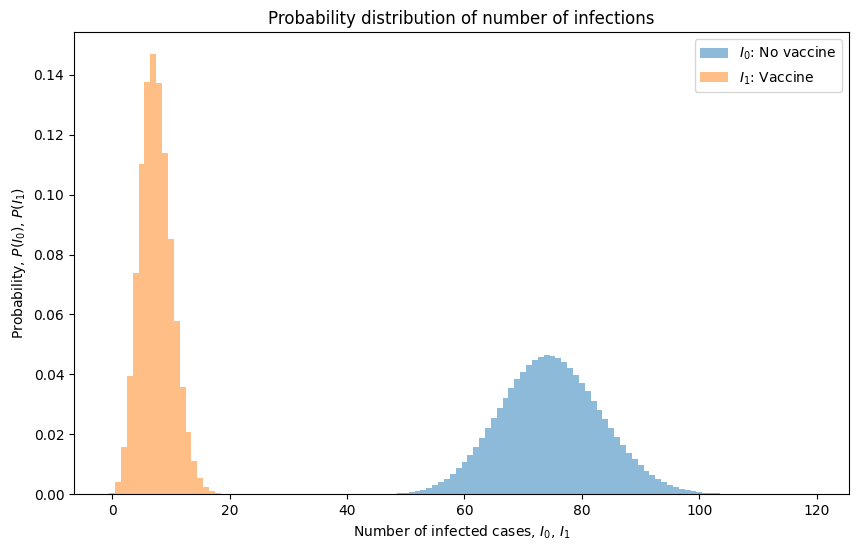

In [28]:
i_range = np.arange(0,120)
pmf0 = binom.pmf(i_range, n0, p0)
pmf1 = binom.pmf(i_range, n0, p1)
plt.figure(figsize=(10, 6))
plt.bar(i_range, pmf0, width=1, label='$I_0$: No vaccine', alpha=0.5)
plt.bar(i_range, pmf1, width=1, label='$I_1$: Vaccine', alpha=0.5)
plt.title("Probability distribution of number of infections")
plt.xlabel("Number of infected cases, $I_0$, $I_1$")
plt.ylabel("Probability, $P(I_0)$, $P(I_1)$")
plt.legend()
plt.show()

Definiamo la funzione di verosimiglianza dell'osservazione simultanea del numero di infetti osservati nei due campioni, $I_0$ e $I_1$, come il prodotto di due binomiali con probabilità che dipendono dal valore di efficienza che viene assunto.

Supponiamo di avere un certo numero di casi osservati, $I_0$ e $I_1$.

In [8]:
# test values
i0, i1 = 75, 11

## Stima dei parametri incogniti

Possiamo determinare la stima di massima verosimiglianza ponendo a zero la derivata della funzione binomiale rispetto al parametro da stimare:

$\displaystyle \left.\frac{\partial\,{\mathrm{Bin}}(n_0; p_0, N_0)}{\partial p_0}\right|_{n_0=I_0} = 0$

e si ottiene:
    
$\displaystyle \widehat{p}_0 = r_0 = \frac{I_0}{N_0}$

$\displaystyle \widehat{p}_1 = \widehat{p}_0(1-\widehat{\varepsilon}) =  r_1 = \frac{I_1}{N_1}$

Da cui:

$\displaystyle \widehat{\varepsilon} = 1 - \frac{\widehat{p}_1}{\widehat{p}_0} = 1 - \frac{r_1}{r_0}$

La tima di $p$ con il campione di controllo di non vaccinati è molto più precisa di quanto più essere una determinazione a partire dal numero di contagi nazionali, perché il campione vaccinato non è necessariamente rappresentativo dell'intera popolazione.

Da notare che, mentre $I_0$ e $I_1$ sono indipendenti, c'è necessariamente correlazione tra le stime $\widehat{p}_0$ e $\widehat{\varepsilon}$ perché c'è una relazione che lega un parametro all'altro.

Il rapporto $\widehat{p}_1/\widehat{p}_0$ viene detto [*risk ratio*](https://sphweb.bumc.bu.edu/otlt/MPH-modules/EP/EP713_Association/EP713_Association3.html).

In [72]:
p0_est, p1_est = i0/n0, i1/n1
eff_est = 1.0 - p1_est/p0_est
print('** Summary **')
print('no vax  : N0 =', n0, 'I0 =', i0, 'p0 = {:.5f}'.format(p0))
print('vax     : N1 =', n1, 'I1 =', i1, 'p1 = {:.5f}'.format(p1))
print('efficacy: ε(est) = {:.5f}'.format(eff_est))

** Summary **
no vax  : N0 = 10000 I0 = 75 p0 = 0.00747
vax     : N1 = 10000 I1 = 11 p1 = 0.00075
efficacy: ε(est) = 0.85333


## Stima delle incertezze

Si potrebbe stimare l'incerezza su $\widehat{p}$ e $\widehat{p}\,(1-\widehat{\varepsilon})$ con un'approssimazione gaussiana delle incertezze binomiali:

$\displaystyle \sigma_{\widehat{p}_0} = \sqrt{\frac{\widehat{p}_0(1-\widehat{p}_0)}{N_0}}$

$\displaystyle \sigma_{\widehat{p}_1} = \sqrt{\frac{\widehat{p}_1(1-\widehat{p}_1)}{N_1}}$


Tuttavia, preferiamo stabilire un metodo non approssimato perché può essere valido anche quando il numero $I_1$ è molto piccolo. Considerando che l'efficienza di un vaccino può essere molto alta, è possibile che $I_1$ sia molto piccolo.

In [73]:
p0_err = math.sqrt(p0_est*(1 - p0_est)/n0)
print("p0 = {:.5f} ± {:.5f}".format(p0, p0_err))

p0 = 0.00747 ± 0.00086


In [74]:
p1_err = math.sqrt(p1_est*(1 - p1_est)/n1)
print("p1 = {:.5f} ± {:.5f}".format(p1, p1_err))

p1 = 0.00075 ± 0.00033


La propagazione degli errori su $\widehat{p}_0/\widehat{p}_1$ richiede la somma in quadratura degli errori relativi.

In [75]:
eff_err = (1 - eff_est)*math.sqrt((p0_err/p0_est)**2+(p1_err/p1_est)**2)
print("ε = {:.3f} ± {:.3f}".format(eff_est, eff_err))

ε = 0.853 ± 0.047


## Stima di massima verosimiglianza

Possiamo definire la funzione di verosimiglianza come prodotto di due PDF binomiali, una per ciascun campione. 

La funzione di verosimiglianza dipenderà da:
* I valori osservati $I_0$, $I_1$
* l'efficacia del vaccino $\varepsilon$
* la probabilità di infezione senza vaccino $p_0$
* il numero di persone non vaccinate e vaccinate, $N_0$ e $N_1$

${\cal L} = p(I_0, I_1; \varepsilon, p_0, N_0, N_1) = {\mathrm{Bin}}(I_0; p_0, N_0)\cdot {\mathrm{Bin}}(I_1; (1-\varepsilon)\,p_0, N_1)$

In [76]:
def likelihood(i0, i1, eff, p0, n0, n1):
    pmf0 = binom.pmf(i0, n0, p0)
    p1 = p0*max(0.0001, 1 - eff)
    pmf1 = binom.pmf(i1, n1, p1)
    lik = pmf0 * pmf1
    return lik

Definiamo una funzione che restituisca $-2\log{\cal L}$ che va minimizzata:

In [77]:
def neg_2log_likelihood(i0, i1, eff, p0, n0, n1):
    return -2*math.log(likelihood(i0, i1, eff, p0, n0, n1))

Definiamo una funzione che calcola il valore minimo a partire da una coppia di valori inziali ```init```:

In [78]:
def max_likelihood(i0, i1, n0, n1, init):
    xopt, fopt, niter, funcalls, warnflag = scipy.optimize.fmin(lambda args:
        neg_2log_likelihood(i0, i1, args[0], args[1], n0, n1), init,
        full_output=True, disp=False)
    return xopt, fopt

Partiamo da valori vicini alla stima finale:

In [80]:
lik_init = [0.85, 0.001]
max_val, f_min = max_likelihood(i0, i1, n0, n1, lik_init)

In [81]:
eff_ml, p0_ml = max_val[0], max_val[1]
p1_ml = p0_ml*(1 - eff_ml)

In [82]:
print('** Summary **')
print('-2lnL min : {:.5f}'.format(f_min))
print('no vax.   : N0 =', n0, 'I0 =', i0, 'p0 = {:.5f}'.format(p0))
print('vax       : N1 =', n1, 'I1 =', i1, 'p1 = {:.5f}'.format(p1))
print('efficacy  : ε(est) = {:.5f}, ε(m.l.) = {:.5f}'.format(eff_est, eff_ml))
print('p0        : true = {:.5f}, est.an. = {:.5f}, m.l. = {:.5f}'.format(p0, p0_est, p0_ml))
print('p1        : true = {:.5f}, est.an. = {:.5f}, m.l. = {:.5f}'.format(p1, p1_est, p1_ml))

** Summary **
-2lnL min : 10.39988
no vax.   : N0 = 10000 I0 = 75 p0 = 0.00747
vax       : N1 = 10000 I1 = 11 p1 = 0.00075
efficacy  : ε(est) = 0.85333, ε(m.l.) = 0.85332
p0        : true = 0.00747, est.an. = 0.00750, m.l. = 0.00750
p1        : true = 0.00075, est.an. = 0.00110, m.l. = 0.00110


Calcoliamo l'intervallo che corrisponde ad una variazione di $-2\log{\cal L}$ di +1. Questo ci fornirà una stima dell'errore migliore di quella con l'approssimazione gaussiana.

In [83]:
def interval_ml():
    if i1 == n1:
        x_lo = 0
    else:
        x_lo = scipy.optimize.root_scalar(lambda x:
            neg_2log_likelihood(i0, i1, x, p0_ml, n0, n1) - f_min - 1, 
            method='bisect', bracket=(0.0, eff_ml), xtol=0.00000001).root
    if i1 == 0:
        x_hi = 1
    else:
        x_hi = scipy.optimize.root_scalar(lambda x:
            neg_2log_likelihood(i0, i1, x, p0_ml, n0, n1) - f_min - 1, 
            method='bisect', bracket=(eff_ml, 0.9999999), xtol=0.00000001).root
    return x_lo, x_hi
int_ml = interval_ml()
print('Int. max. lik.: ε[{:.3f}, {:.3f}]'.format(int_ml[0], int_ml[1]))
print('ε = {:.3f} +{:.3f}/-{:.3f} (asym.)'.format(eff_ml, int_ml[1] - eff_ml,eff_ml - int_ml[0]))
print("ε = {:.3f} ±{:.3f} (sym.)".format(eff_est, eff_err))

Int. max. lik.: ε[0.805, 0.893]
ε = 0.853 +0.040/-0.049 (asym.)
ε = 0.853 ±0.047 (sym.)


In [84]:
x_range = np.linspace(0.0, 1, 1000)
y = []
for x in x_range:
    y.append(neg_2log_likelihood(i0, i1, x, p0_ml, n0, n1))
y_lik = np.array(y) - f_min
y_range = [0, np.max(y_lik)]

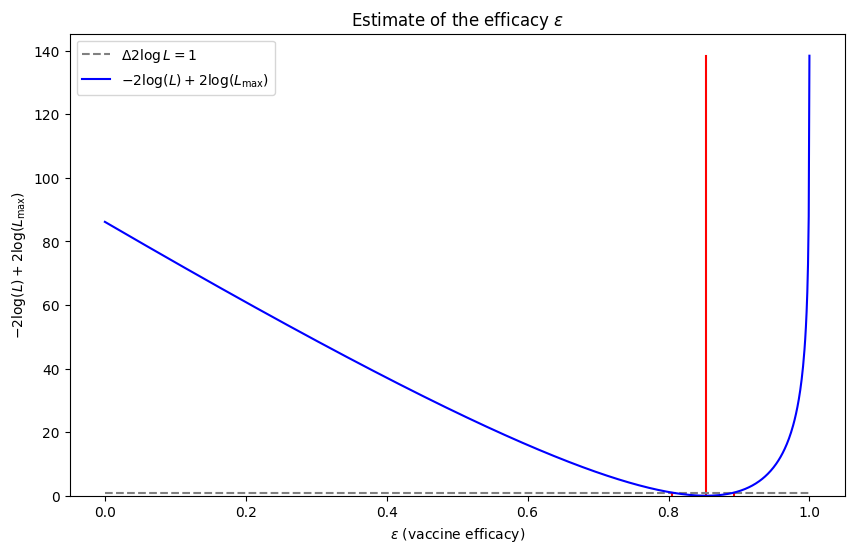

In [85]:
plt.figure(figsize=(10, 6))
plt.plot([eff_ml, eff_ml], y_range, color='red')
plt.plot([0, 1], [1, 1], label=r"$\Delta 2\log L = 1$", color='gray', linestyle='--')
plt.plot([int_ml[0],int_ml[0]], [0, 1], color='red')
plt.plot([int_ml[1],int_ml[1]], [0, 1], color='red')
plt.plot(x_range, y_lik, label=r"$-2\log(L) + 2\log(L_{\mathrm{max}})$", color='blue')
plt.title(r"Estimate of the efficacy $\varepsilon$")
plt.xlabel(r"$\varepsilon$ (vaccine efficacy)")
plt.ylabel(r"$-2\log(L) + 2\log (L_{\mathrm{max}})$")
plt.legend()
plt.ylim(0)
plt.show()

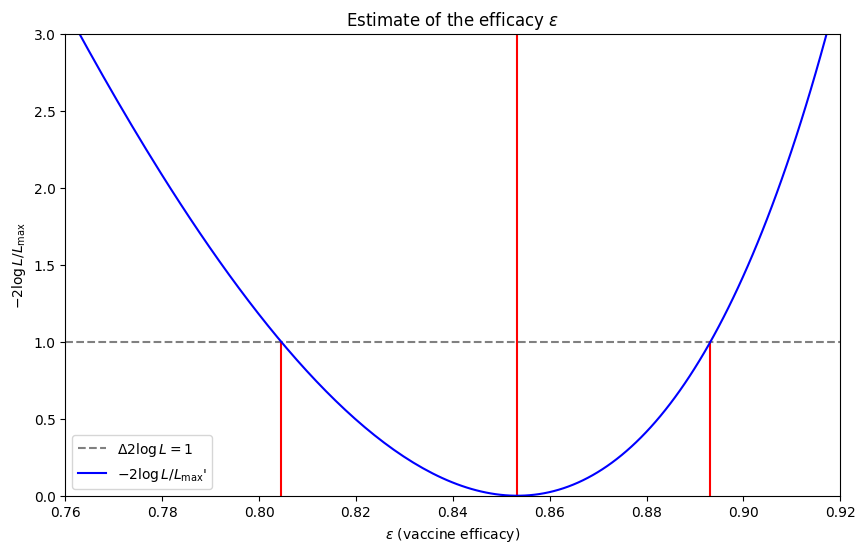

In [51]:
plt.figure(figsize=(10, 6))
plt.plot([eff_ml, eff_ml], y_range, color='red')
plt.plot([0, 1], [1, 1], label=r"$\Delta 2\log L = 1$", color='gray', linestyle='--')
plt.plot([int_ml[0],int_ml[0]], [0, 1], color='red')
plt.plot([int_ml[1],int_ml[1]], [0, 1], color='red')
plt.plot(x_range, y_lik, label=r"$-2\log L/L_{\mathrm{max}}$'", color='blue')
plt.title(r"Estimate of the efficacy $\varepsilon$")
plt.xlabel(r"$\varepsilon$ (vaccine efficacy)")
plt.ylabel(r"$-2\log L/L_{\mathrm{max}}$")
plt.legend()
plt.ylim(0,3)
plt.xlim(0.76,0.92)
plt.show()

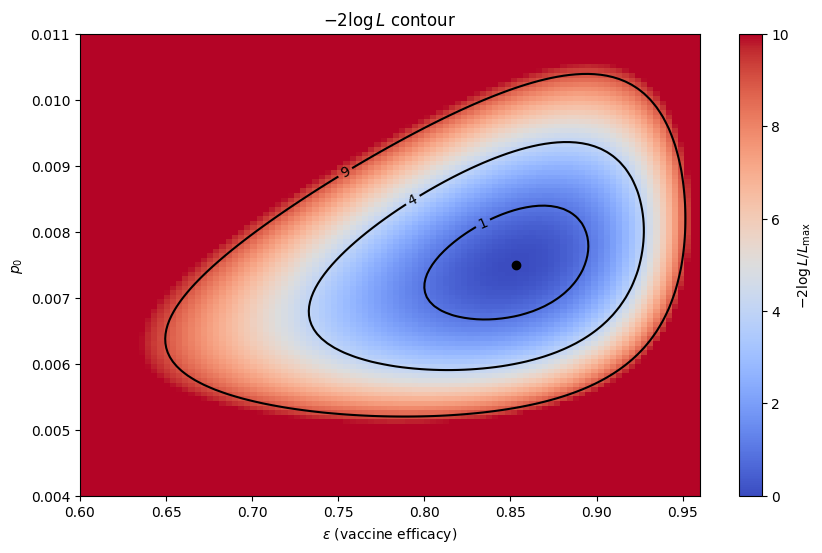

In [87]:
nptx, npty = 101, 101
x_p = np.linspace(0.60, 0.96, nptx)
y_p = np.linspace(0.004, 0.011, npty)
x, y = np.meshgrid(x_p, y_p)
f = lambda eff, p0: np.vectorize(neg_2log_likelihood)(i0, i1, eff, p0, n0, n1) - f_min
z = f(x, y)
figure, ax = plt.subplots(figsize=(10, 6))
col = ax.pcolormesh(x, y, z, cmap='coolwarm', vmin=0, vmax=10, shading='auto')
con = ax.contour(x, y, z, [1, 4, 9], colors='black')
ax.scatter([eff_ml], [p0_ml], color='black')
ax.clabel(con, inline=1, fontsize=10)
ax.set_title('$-2\log L$ contour')
ax.axis([x.min(), x.max(), y.min(), y.max()])
ax.set_xlabel(r"$\varepsilon$ (vaccine efficacy)")
ax.set_ylabel('$p_0$')
figure.colorbar(col, label='$-2\log L/L_{\mathrm{max}}$')
plt.show()